## Imports and auxiliar functions


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
from skimage.transform import radon, iradon
from skimage.metrics import peak_signal_noise_ratio
import matplotlib.pyplot as plt

import time

def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

def plot_images(original, transformed, num_realizations):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(original, cmap='gray')
    plt.title('Shepp-Logan Phantom')

    plt.subplot(1, 3, 2)
    plt.imshow(transformed, cmap='gray', extent=(0, 180, 0, num_realizations), aspect='auto')
    plt.title('Radon Transform')
    plt.xlabel('Projection Angle (degrees)')
    plt.ylabel('Realizations')

    reconstructed = iradon(transformed, theta=np.linspace(0., 180., transformed.shape[1]), circle=True)
    plt.subplot(1, 3, 3)
    plt.imshow(reconstructed, cmap='gray')
    plt.title('Reconstructed Image')

    plt.show()

def plot_images2(im, sinog, ground_truth, mse, psnr, num_realizations=180):
    plt.figure(figsize=(16, 4))

    plt.subplot(1, 4, 1)
    plt.imshow(im, cmap='gray', vmin=0, vmax=1)
    plt.title('Reconstructed Image')

    plt.subplot(1, 4, 2)
    plt.imshow(sinog, cmap='gray', extent=(0, 180, 0, num_realizations), aspect='auto')
    plt.title('Radon Transform')
    plt.xlabel('Projection Angle (degrees)')
    plt.ylabel('Realizations')

    plt.subplot(1, 4, 3)
    plt.plot(range(1,len(mse)+1), mse)
    plt.title('MSE')

    plt.subplot(1, 4, 4)
    plt.plot(range(1,len(psnr)+1), psnr)
    plt.title('PSNR')

    plt.show()

def radon_transform(image, num_angles):
    angles = torch.linspace(0.0, 180.0, steps=num_angles)
    radon_images = []
    for angle in angles:
        rotated_image = TF.rotate(image.unsqueeze(0), angle.item())
        projection = torch.sum(rotated_image.squeeze(0), dim=0)
        radon_images.append(projection)

    return torch.stack(radon_images, dim=0)

def get_img_tensor(im, length1):
    img = Image.fromarray(im)
    transform = Compose([
        Resize((length1)),
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
    img = transform(img)
    return img

def normalize(data):
    max = data.max()
    min = data.min()
    return (data-min)/(max-min)

def psnr(img1, img2):
    mse = F.mse_loss(img1, img2)
    max_pixel_value = torch.max(img2)
    psnr = 20 * torch.log10(max_pixel_value / torch.sqrt(mse))
    return psnr.item()

def Gaussian_Noise(sinog_shape):
  noise = np.random.normal(0, 1, size =sinog_shape)
  return noise

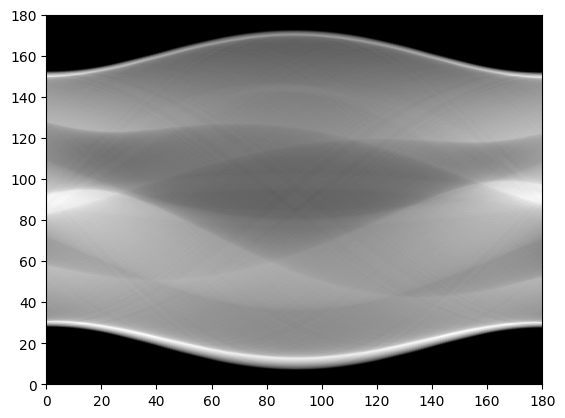

In [ ]:
img = skimage.data.shepp_logan_phantom()

num_realizations = 180
angles = np.linspace(0, 180, num_realizations, endpoint=False)
sinog = radon(img, theta=angles, circle=True)

plt.imshow(sinog, cmap='gray', extent=(0, 180, 0, num_realizations), aspect='auto')

## Siren Model

In [ ]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.

    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a
    # hyperparameter.

    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)

    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                             1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                             np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))

    def forward_with_intermediate(self, input):
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate


class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False,
                 first_omega_0=20, hidden_omega_0=20.):
        super().__init__()

        self.net = []
        self.net.append(SineLayer(in_features, hidden_features,
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features,
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)

            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0,
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)

            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features,
                                      is_first=False, omega_0=hidden_omega_0))

        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)

                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()

                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else:
                x = layer(x)

                if retain_grad:
                    x.retain_grad()

            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

## Data Model

In [ ]:
class ImageFitting(Dataset):
    def __init__(self, img, length1):
        super().__init__()
        img = get_img_tensor(img, length1)
        self.pixels = img.permute(1, 2, 0).view(-1, 1)
        self.coords = get_mgrid(length1, 2)

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        if idx > 0: raise IndexError

        return self.coords, self.pixels

## Initializing model and data

In [ ]:
# Establish seed for reproducibility
torch.manual_seed(42)

img = skimage.data.shepp_logan_phantom()
phantom = ImageFitting(img, 400)
dataloader = DataLoader(phantom, batch_size=1, pin_memory=True, num_workers=0)

img_siren = Siren(in_features=2, out_features=1, hidden_features=256,
                  hidden_layers=3, outermost_linear=True)
img_siren.cuda()

Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

## Running Model

In [ ]:
mse_losses = []
psnr_losses = []

img_mse_losses = []
img_psnr_losses = []

save_diffs = []

In [ ]:
total_steps = 4001 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 200

optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())
#optim = torch.optim.Adagrad(lr=1e-3, params=img_siren.parameters())

num_realizations = 100
angles = np.linspace(0, 180, num_realizations, endpoint=False)

model_input, ground_truth = next(iter(dataloader))
sinog_tensor = radon_transform(ground_truth.cpu().view(400,400)*0.5 + 0.5,num_realizations)

noise = Gaussian_Noise(sinog_tensor.shape)
sinog_tensor_bruite = sinog_tensor+noise
sinog_tensor_bruite = np.clip(sinog_tensor_bruite, sinog_tensor.min(), sinog_tensor.max())

s1 = normalize(sinog_tensor_bruite.detach().numpy())

model_input, ground_truth = model_input.cuda(), ground_truth.cuda()
i1 = ground_truth.cpu().detach().numpy()

# original_img = ground_truth.cpu().view(400,400)*0.5 + 0.5
# rd_transform = radon(original_img, theta=angles, circle=True)

for step in range(total_steps):
    if step >0 :
        past_output = model_output

    model_output, coords = img_siren.forward(model_input)
    pred = model_output.clone()

    sinog_aux = radon_transform(pred.cpu().view(400,400),num_realizations)

    mse_loss = ((sinog_aux - sinog_tensor)**2).mean()

    s2 = normalize(sinog_aux.detach().numpy())
    psnr_loss = peak_signal_noise_ratio(s1, s2)

    mse_losses.append(mse_loss.item())
    psnr_losses.append(psnr_loss)

    img_mse_loss = ((pred.cpu().view(400,400).detach().numpy() - img)**2).mean()
    img_psnr_loss = peak_signal_noise_ratio(img, pred.cpu().view(400,400).detach().numpy().astype('float64'))

    img_mse_losses.append(img_mse_loss.item())
    img_psnr_losses.append(img_psnr_loss)

    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, mse_loss))

        plot_images2(pred.cpu().view(400,400).detach().numpy(), sinog_aux.detach().numpy(), sinog_tensor, img_mse_losses, img_psnr_losses)

    if step > 0 and psnr_loss-psnr_losses[-2] < -2:
        print("Decrease identified in step %d" % (step))

        save_diffs.append(abs((model_output - past_output).cpu().view(400,400).detach().numpy()))

    optim.zero_grad()
    mse_loss.backward()
    optim.step()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
(sinog_aux.detach().numpy()).max()

104.27371

In [ ]:
peak_signal_noise_ratio(img,pred.cpu().view(400,400).detach().numpy())

<ipython-input-12-b13c3bda6525>:1: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  peak_signal_noise_ratio(img,pred.cpu().view(400,400).detach().numpy())


27.84008480535634

In [ ]:
pred.cpu().view(400,400).detach().numpy().astype('float64').dtype

dtype('float64')

In [ ]:
print(img_mse_losses[-1])
print(img_psnr_losses[-1])

0.0016443396136270338
27.84008480535634


In [ ]:
((img - pred.cpu().view(400,400).detach().numpy())**2).mean()

0.0016443396136270338

In [ ]:
torch.max(ground_truth)

tensor(1., device='cuda:0')

In [ ]:
len(mse_losses)

4001

In [ ]:
min(mse_losses)

0.6152499318122864

In [ ]:
max(psnr_losses)

34.45558703262404

In [ ]:
torch.max(sinog_tensor)

tensor(107.2000)

In [ ]:
torch.save(img_siren.state_dict(),'im_denoise_1e4_2000_50_false.pth')

In [ ]:
len(save_diffs)

16

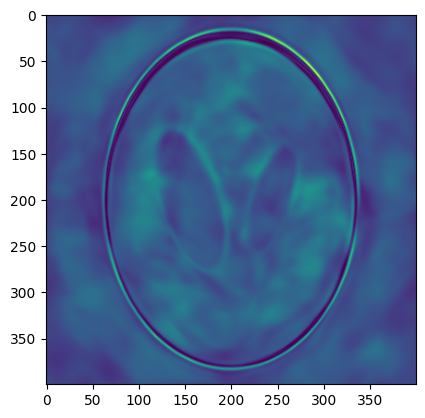

In [ ]:
plt.imshow(save_diffs[5], cmap='viridis')

In [ ]:
np.save('im_denoise_1e4_2000_50_savediffs_false.npy',np.array(save_diffs))

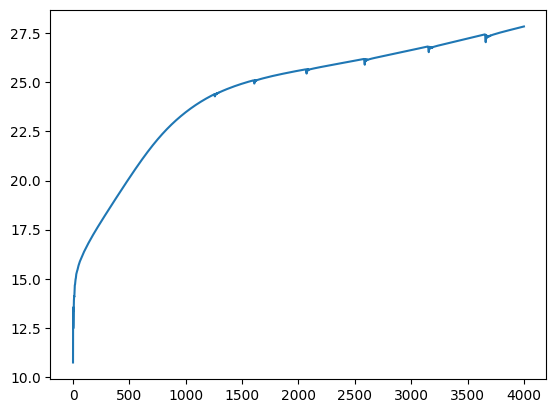

In [ ]:
plt.plot(img_psnr_losses)

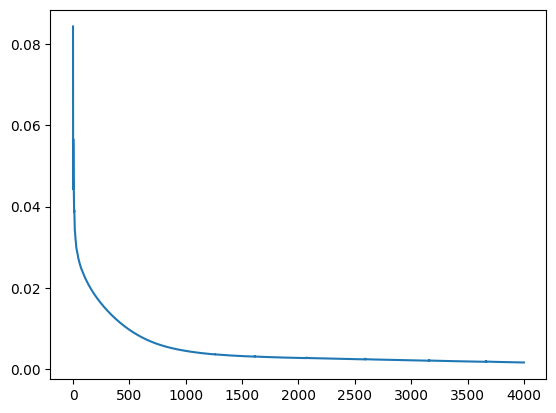

In [ ]:
plt.plot(img_mse_losses)